In [2]:
from skimage.transform import pyramid_gaussian
from skimage.draw import rectangle_perimeter
from skimage.util import view_as_windows
from skimage.io import imread, imshow, imsave
from skimage.feature import hog
import numpy as np
import pickle
import time
import os

In [3]:
def loadModel(path=""):
    """
    Load persisted model
    """
    with open(path+'modelPkl' , 'rb') as files:
        model = pickle.load(files)
        
    return model

In [4]:
def loadImgs(srcPath):
    """
    Returns:
        - images (List): List of rgb images
    """
    images = []
    for filename in os.listdir(srcPath):
        img = imread(os.path.join(srcPath, filename))
        images.append(img)

    
    return images

In [5]:
def buildPyramid(img, scale=2):
    """
    Returns:
        - imgs(generator): pyramid of images
    """
    # rows, cols, dim = img.shape
    pyramid = tuple(pyramid_gaussian(img, downscale=scale, channel_axis=-1))
    return pyramid

In [6]:
def getWindows(pymImg,shape=(128,64,3)):
    windows = view_as_windows(pymImg, shape, step=(32,16,3))
    return windows

In [7]:
def HOG(img):
    # imshow(img)
    hogImg = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
        block_norm='L2', feature_vector=True, channel_axis=-1) # feature vector= true, channel_Axis=2
    return hogImg


In [8]:
def predictPed(img):
    """
    Returns:
        - detection (Bool)
    """
    model = loadModel()
    ans = model.predict(img.reshape(1, -1))
    score = model.predict_proba(img.reshape(1, -1))

    return ans, score

In [20]:
def nmsScore(candidates,threshold=0.3):
    print(candidates)
    # grab the coordinates of the bounding boxes
    x1 = candidates[:,0]
    y1 = candidates[:,1]
    x2 = candidates[:,2]
    y2 = candidates[:,3]
    #idxs = np.argsort(y2)
    # sort by scores
    idxs = np.argsort(candidates[:,4])
    # print(f'idxs: {idxs}')
    selected = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        last_idx = idxs[last]
        xx1 = np.maximum(x1[last_idx], x1[idxs[:last]])
        yy1 = np.maximum(y1[last_idx], y1[idxs[:last]])
        xx2 = np.minimum(x2[last_idx], x2[idxs[:last]])
        yy2 = np.minimum(y2[last_idx], y2[idxs[:last]])
        box_areas = (candidates[:,2]-candidates[:,0])*(candidates[:,3]-candidates[:,1])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        c_areas = (w*h)/box_areas[last]
        areas = np.concatenate((c_areas,np.array([1])))
        # print('Areas:',areas)
        overlap_threshold = np.where(areas>threshold)
        # print(idxs[overlap_threshold])
        overlap_scores = candidates[idxs[overlap_threshold],4]
        # print(overlap_scores)
        max_score_index = np.argmax(overlap_scores)
        select_idx = idxs[overlap_threshold][max_score_index]
        selected.append(candidates[select_idx])
        # print('Delete:',overlap_threshold)
        idxs = np.delete(idxs,overlap_threshold)
    print('Selected->',selected)
    return selected

In [9]:
def scaleCoords(x,y, level, f):
    
    x = (int(x*(f**(level-1))))
    y = (int(y*(f**(level-1))))
    
    return x, y
# scale_coords(xy_5,level,f)

In [10]:
def getCoords(row,col,level):
    if level != 0: 
        row,col = scaleCoords(row,col,level, 2)
    
    start = ((32 * row)* (2**level), (16 * col)* (2**level))
    end = (((128 + (32 * row))* (2**level)), ((64 + (16 * col))* (2**level)))
    return start, end

In [11]:
def drawBox(img, coords):
    newImg = img.copy()

    start, end = (coords[0],coords[1]), (coords[2], coords[3])
    
    try:
        rr, cc = rectangle_perimeter(start, end, clip=True, shape=img.shape)
        newImg[rr,cc] = [0,255,0]
        newImg[rr+1,cc+1] = [0,255,0]
        newImg[rr-1,cc-1] = [0,255,0]
    except:
        pass

    return newImg

In [36]:
def runDetector(img):
    """ """
    complete = []
    # all1 = np.zeros()
    all1 = []
    img2 = img.copy()
    img3 = img.copy()
    all1.append([100, 70, 120, 90, 0.580001])

    # for img in imgs: 
    pyramid = buildPyramid(img)
    for level, pymImg in enumerate(pyramid):
        print(level)
        if pymImg.shape >= (128,64,3):
            window = getWindows(pymImg,(128,64,3))
            rows,cols = window.shape[0], window.shape[1]
            for row in range(rows):
                for col in range(cols):
                    hogWindow = HOG(window[row,col,0])
                    ans, score = predictPed(hogWindow)
                    # print(ans, score[0][int(ans)],int(ans))
                    if ans == 1:
                        accScore = score[0][int(ans)]
                        start, end = getCoords(row,col,level)
                        # print(start, end)
                        # print(row,col)
                        all1.append([start[0],start[1],end[0],end[1],accScore])
                        img2 = drawBox(img2, (start[0],start[1],end[0],end[1]))              
        else: 
            break
    
    # applicar NMS
    # necesito coordenada start, end y score
    print("all detected qty. ", len(all1))
    all1 = np.array(all1)
    selected = nmsScore(all1)
    print("all selected from detected qty. ",len(selected))

    for i in selected:
        img3 = drawBox(img3,i)

    return complete, img2, img3


In [14]:
img = imread(os.path.join("85.jpeg"))
centralPark = imread(os.path.join("Central_Park,_NYC_(May_2014)_-_23.JPG"))
Berlin = imread(os.path.join("Berlin_2020_12_04_441-1024x683.jpg"))
eval1 = imread(os.path.join("imgsEval/052.jpg"))
eval2 = imread(os.path.join("imgsEval/GettyImages-1000051198-1160x773.jpg"))
eval3 = imread(os.path.join("imgsEval/paris-courir-quais.jpg"))
eval4 = imread(os.path.join("imgsEval/Paris-metro-stations-rush-hour.jpg"))

## IMG PEQ

In [37]:
x, img2, img3 = runDetector(img)

0
1
2
all detected qty.  6
[[100.          70.         120.          90.           0.580001  ]
 [ 96.          16.         224.          80.           0.50214942]
 [ 96.          48.         224.         112.           0.50297149]
 [ 96.         176.         224.         240.           0.50128201]
 [128.         112.         256.         176.           0.53514191]
 [128.         144.         256.         208.           0.53465744]]
Selected-> [array([100.      ,  70.      , 120.      ,  90.      ,   0.580001]), array([128.        , 112.        , 256.        , 176.        ,
         0.53514191]), array([ 96.        ,  48.        , 224.        , 112.        ,
         0.50297149]), array([ 96.        , 176.        , 224.        , 240.        ,
         0.50128201])]
all selected from detected qty.  4


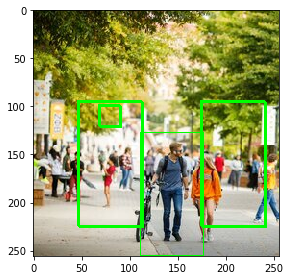

In [38]:
imshow(img3)

In [22]:
# Christian
array([128.        , 112.        , 256.        , 176.        ,0.53514191]), 
array([100.        ,  70.        , 120.        ,  90.        ,0.53514191]), 
array([ 96.        ,  48.        , 224.        , 112.        ,0.50297149]), 
array([ 96.        , 176.        , 224.        , 240.        ,0.50128201])]


SyntaxError: unmatched ']' (3037647055.py, line 5)

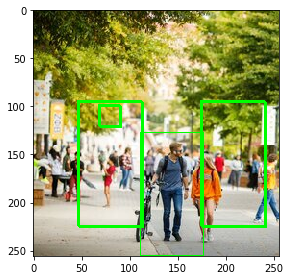

In [34]:
imshow(img3)

## Berlin

In [24]:
x, Berlin2, Berlin3 = runDetector(Berlin)

0
1
2
3
all detected qty.  29
[[1.00000000e+02 7.00000000e+01 1.20000000e+02 9.00000000e+01
  5.35141910e-01]
 [1.28000000e+02 4.16000000e+02 2.56000000e+02 4.80000000e+02
  5.02208867e-01]
 [2.24000000e+02 8.00000000e+01 3.52000000e+02 1.44000000e+02
  5.02291590e-01]
 [2.56000000e+02 1.28000000e+02 3.84000000e+02 1.92000000e+02
  5.03408371e-01]
 [2.56000000e+02 2.88000000e+02 3.84000000e+02 3.52000000e+02
  5.02214642e-01]
 [2.56000000e+02 7.84000000e+02 3.84000000e+02 8.48000000e+02
  5.00368842e-01]
 [2.88000000e+02 4.32000000e+02 4.16000000e+02 4.96000000e+02
  5.04648547e-01]
 [2.88000000e+02 4.48000000e+02 4.16000000e+02 5.12000000e+02
  5.02272596e-01]
 [2.88000000e+02 9.12000000e+02 4.16000000e+02 9.76000000e+02
  5.08548986e-01]
 [3.20000000e+02 2.88000000e+02 4.48000000e+02 3.52000000e+02
  5.12242395e-01]
 [3.20000000e+02 3.04000000e+02 4.48000000e+02 3.68000000e+02
  5.24409197e-01]
 [3.20000000e+02 3.36000000e+02 4.48000000e+02 4.00000000e+02
  5.01145035e-01]
 [3.200000

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(Berlin2)
plt.show()

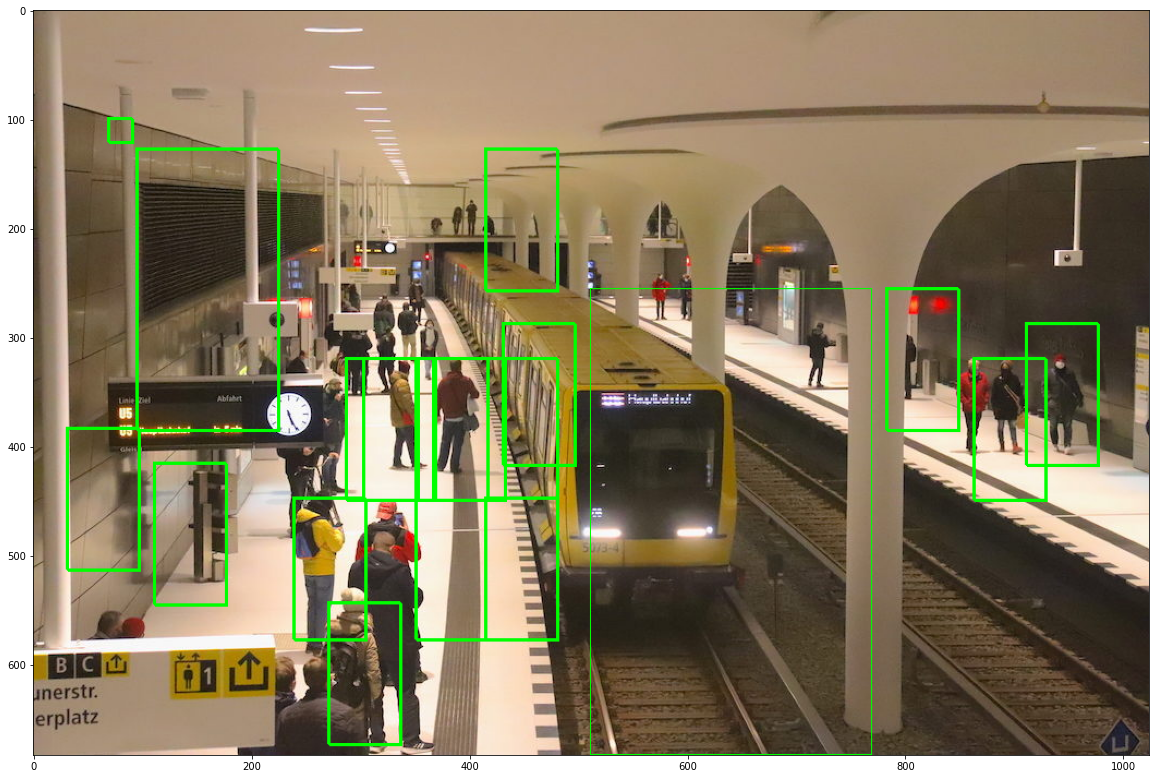

In [25]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(Berlin3)
plt.show()

## Central Park

In [ ]:
x, centralPark2, centralPark3, centralPark4, centralPark5 = runDetector(centralPark[:1000,2400:])

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(centralPark[:1000,2400:])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(centralPark3)
plt.show()

In [ ]:
img2 = drawBox(img, (3,1,0))

In [ ]:
img.shape

In [ ]:
window = getWindows(img,(128,64,3))
window.shape
# imshow(window[1][235][0])
# window.shape

In [ ]:
x = drawBox(img, [32, 3760,160, 3824,0])
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(x)
plt.show()

In [ ]:
row, col, level = (1,2,3)
row